<a href="https://colab.research.google.com/github/Re14m/isk/blob/master/2022_0223_house_prices_advanced_regression_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Kaggle APIのインストール
!pip install kaggle

In [3]:
#jsonで認証
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [6]:
#datasetダウンロード
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.0MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 63.5MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 32.7MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 98.1MB/s]


In [7]:
#ライブラリのインポート
import numpy as np 
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#pandasのカラムが100列まで見れるようにする
pd.set_option('display.max_columns', 100)

In [9]:
# 学習データの読み込み
train_df = pd.read_csv('train.csv',index_col=0)

# 先頭5行をみてみる。
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
歪度: 1.8829
尖度: 6.5363


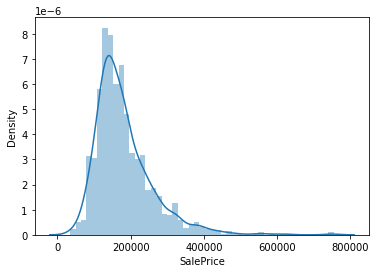

In [10]:
# 売却価格のヒストグラム
sns.distplot(train_df['SalePrice'])

# 売却価格の概要をみてみる
print(train_df["SalePrice"].describe())
print(f"歪度: {round(train_df['SalePrice'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePrice'].kurt(),4)}" )

In [ ]:
# 予測用データセットの読み込み
test_df = pd.read_csv('test.csv',index_col=0)

# 学習データの説明変数と、予測用データを結合
all_df = pd.concat([train_df.drop(columns='SalePrice'),test_df])

In [ ]:
#MSSubClass,YrSold,MoSoldをカテゴリ変数に変換
num2str_list = ['MSSubClass','YrSold','MoSold']
for column in num2str_list:
    all_df[column] = all_df[column].astype(str)

In [ ]:
# 変数の型ごとに欠損値の扱いが異なるため、変数ごとに処理
for column in all_df.columns:
    # dtypeがobjectの場合、文字列の変数
    if all_df[column].dtype=='O':
        all_df[column] = all_df[column].fillna('None')
    # dtypeがint , floatの場合、数字の変数
    else:
        all_df[column] = all_df[column].fillna(0)

In [ ]:
# 特徴量エンジニアリングによりカラムを追加する関数
def add_new_columns(df):
    # 建物内の総面積 = 1階の面積 + 2階の面積 + 地下の面積
    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]

    # 一部屋あたりの平均面積 = 建物の総面積 / 部屋数
    df['AreaPerRoom'] = df['TotalSF']/df['TotRmsAbvGrd']

    # 築年数 + 最新リフォーム年 : この値が大きいほど値段が高くなりそう
    df['YearBuiltPlusRemod']=df['YearBuilt']+df['YearRemodAdd']

    # お風呂の総面積
    # Full bath : 浴槽、シャワー、洗面台、便器全てが備わったバスルーム
    # Half bath : 洗面台、便器が備わった部屋)(シャワールームがある場合もある)
    # シャワーがない場合を想定してHalf Bathには0.5の係数をつける
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

    # 合計の屋根付きの玄関の総面積 
    # Porch : 屋根付きの玄関 日本風にいうと縁側
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

    # プールの有無
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

    # 2階の有無
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    # ガレージの有無
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

    # 地下室の有無
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

    # 暖炉の有無
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# カラムを追加
add_new_columns(all_df)

In [ ]:
# pd.get_dummiesを使うとカテゴリ変数化できる。
all_df = pd.get_dummies(all_df)
all_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,AreaPerRoom,YearBuiltPlusRemod,TotalBathrooms,TotalPorchSF,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2566.0,320.750000,4006,3.5,61,0,1,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,2524.0,420.666667,3952,2.5,298,0,0,1,1,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,2706.0,451.000000,4003,3.5,42,0,1,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2473.0,353.285714,3885,2.0,307,0,1,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,3343.0,371.444444,4000,3.5,276,0,1,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
# 外れ値を殺す。学習データと予測データに分割して元のデータフレームに戻す。
train_df = pd.merge(all_df.iloc[train_df.index[0]:train_df.index[-1]],train_df['SalePrice'],left_index=True,right_index=True)
test_df = all_df.iloc[train_df.index[-1]:]
train_df = train_df[(train_df['LotArea']<20000) & (train_df['SalePrice']<400000)& (train_df['YearBuilt']>1920)]

歪度: 0.9491
尖度: 0.7481


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


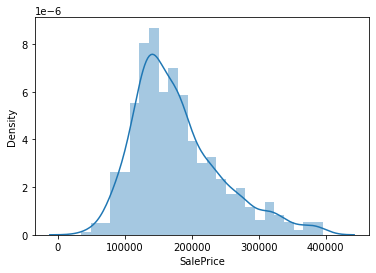

In [ ]:
# 対数変換前のヒストグラム、歪度、尖度
sns.distplot(train_df['SalePrice'])
print(f"歪度: {round(train_df['SalePrice'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePrice'].kurt(),4)}" )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: -0.0947
尖度: 0.3165


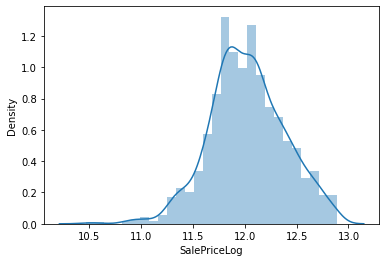

In [ ]:
# SalePriceLogに対数変換した値を入れる。説明の都合上新たなカラムを作るが、基本的にそのまま代入して良い。
# np.log()は底がeの対数変換を行う。
train_df['SalePriceLog'] = np.log(train_df['SalePrice'])
# 対数変換後のヒストグラム、歪度、尖度
sns.distplot(train_df['SalePriceLog'])
print(f"歪度: {round(train_df['SalePriceLog'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePriceLog'].kurt(),4)}" )

In [ ]:
# 学習データ、説明変数
train_X = train_df.drop(columns = ['SalePrice','SalePriceLog'])
# 学習データ、目的変数
train_y = train_df['SalePriceLog']

# 予測データ、目的変数
test_X = test_df

In [ ]:
#ハイパーパラメータチューニング
def lasso_tuning(train_x,train_y):
    # alphaパラメータのリスト
    param_list = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] 

    for cnt,alpha in enumerate(param_list):
        # パラメータを設定したラッソ回帰モデル
        lasso = Lasso(alpha=alpha) 
        # パイプライン生成
        pipeline = make_pipeline(StandardScaler(), lasso)

        # 学習データ内でホールドアウト検証のために分割 テストデータの割合は0.3 seed値を0に固定
        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)

        # 学習
        pipeline.fit(X_train,y_train)

        # RMSE(平均誤差)を計算
        train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
        test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
        # ベストパラメータを更新
        if cnt == 0:
            best_score = test_rmse
            best_param = alpha
        elif best_score > test_rmse:
            best_score = test_rmse
            best_param = alpha

    # ベストパラメータのalphaと、そのときのMSEを出力
    print('alpha : ' + str(best_param))
    print('test score is : ' +str(round(best_score,4)))

    # ベストパラメータを返却
    return best_param

# best_alphaにベストパラメータのalphaが渡される。
best_alpha = lasso_tuning(train_X,train_y)

alpha : 0.001
test score is : 0.1264


In [ ]:
# ラッソ回帰モデルにベストパラメータを設定
lasso = Lasso(alpha = best_alpha)
# パイプラインの作成
pipeline = make_pipeline(StandardScaler(), lasso)
# 学習
pipeline.fit(train_X,train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.001))])

In [ ]:
# 結果を予測
pred = pipeline.predict(test_X)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: 0.2544
尖度: 1.1735


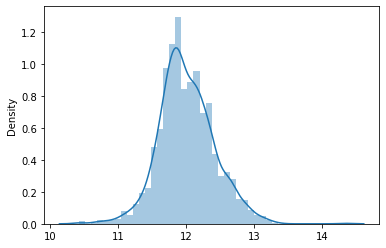

In [ ]:
# 予測結果のプロット
sns.distplot(pred)
# 歪度と尖度
print(f"歪度: {round(pd.Series(pred).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred).kurt(),4)}" )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: 4.5848
尖度: 60.9279


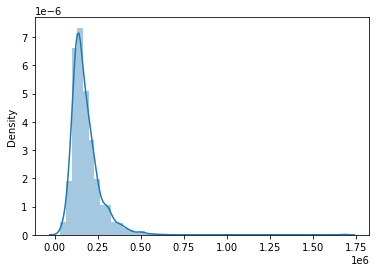

In [ ]:
# 指数変換
pred_exp = np.exp(pred)
# 指数変換した予測結果をプロット
sns.distplot(pred_exp)
# 歪度と尖度
print(f"歪度: {round(pd.Series(pred_exp).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred_exp).kurt(),4)}" )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: 1.0079
尖度: 0.9016


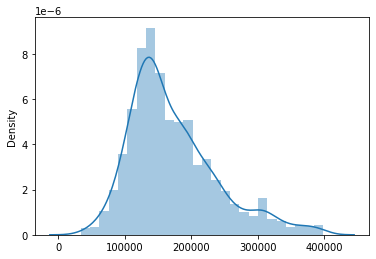

In [ ]:
# 400,000より高い物件は除去
pred_exp_ex_outliars = pred_exp[pred_exp<400000]
# 指数変換した予測結果をプロット
sns.distplot(pred_exp_ex_outliars)
# 歪度と尖度
print(f"歪度: {round(pd.Series(pred_exp_ex_outliars).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred_exp_ex_outliars).kurt(),4)}" )

歪度: 0.9491
尖度: 0.7481


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


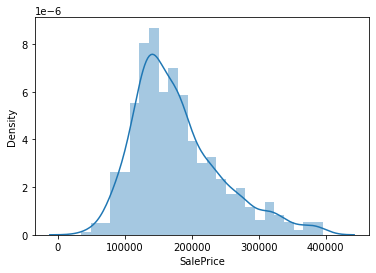

In [ ]:
# 学習データの住宅価格をプロット(外れ値除去済み)
sns.distplot(train_df['SalePrice'])
# 歪度と尖度
print(f"歪度: {round(pd.Series(train_df['SalePrice']).skew(),4)}" )
print(f"尖度: {round(pd.Series(train_df['SalePrice']).kurt(),4)}" )

In [ ]:
#提出用データsample_submission.csvを見る
# sample_submission.csvの読み込み
submission_df = pd.read_csv('sample_submission.csv')
# sample_submission.csvの形式を確認するために先頭五行を見てみる。
submission_df.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [ ]:
# 指数変換した値を代入
submission_df['SalePrice'] = pred_exp

In [ ]:
# submission.csvを出力
submission_df.to_csv('submission.csv',index=False)